In [217]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [218]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [219]:
len(words)

32033

In [220]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [221]:
# build the dataset example

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:2]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


In [222]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [223]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [224]:
C = torch.rand((27, 2)) # 27 characters embedded in 2 dimensional space

In [225]:
# Advanced Indexing: See notes in Notion

emb = C[X]
emb.shape # Here 228146 context of block size 3 has 2 dimensional space representation

torch.Size([228146, 3, 2])

In [226]:
W1 = torch.rand((6, 100)) # 3 embeddings in 2 dimensional space = 6 inputs. 100 is arbritrary
b1 = torch.rand(100)

In [227]:
emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape # get first second and third context respectively

(torch.Size([228146, 2]), torch.Size([228146, 2]), torch.Size([228146, 2]))

In [228]:
# Concatenate them for input layer

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [229]:
# Generalizing

torch.cat(torch.unbind(emb, 1), dim=1).shape # Unbind removes the dimension but not efficient as a whole new memory is used

torch.Size([228146, 6])

In [230]:
# Most efficient way

emb.view(emb.shape[0], 6).shape

torch.Size([228146, 6])

In [231]:
# Continuing...

# 1 - First layer
h = emb.view(emb.shape[0], 6) @ W1 + b1
h.shape

torch.Size([228146, 100])

In [232]:
# 2 - Activation Function

h = torch.tanh(h)
h.shape

torch.Size([228146, 100])

In [233]:
# 3 - Final Layer

W2 = torch.rand((100, 27)) # 27 output characters
b2 = torch.rand(27)

In [234]:
logits = h @ W2 + b2 # [228146, 27]
logits.shape

torch.Size([228146, 27])

In [235]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True) # Softmax
prob.shape # number of contexts and 27 probabilities of next possible character

torch.Size([228146, 27])

In [236]:
prob[torch.arange(prob.shape[0]), Y] # probabilities of correct next character. prob.shape[0] = 228146. arange gives 0 to 228146

tensor([7.9704e-04, 4.5168e-04, 2.9232e-04,  ..., 3.6355e-01, 4.6720e-04,
        3.4588e-04])

In [237]:
# Negative log likelihood

loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss # mean of all the loss in 228146

tensor(7.2301)

In [238]:
# Now using cross_entropy

F.cross_entropy(logits, Y)

tensor(7.2301)

In [239]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

## FINALLY

In [240]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [241]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [242]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [243]:
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [244]:
lre = torch.linspace(-3, 0, 1000) # can be used for variable learning rate to FIND OUT THE LEARNING RATE
lrs = 10**lre

In [245]:
lri = []
lossi = []
stepi = []

In [246]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # lowest value, highest value, size. get random 32 number of Xtr
  
  # forward pass
  emb = C[Xtr[ix]] # # Here 32 mini batch context of block size 3 has 10 dimensional space representation (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.8224812746047974


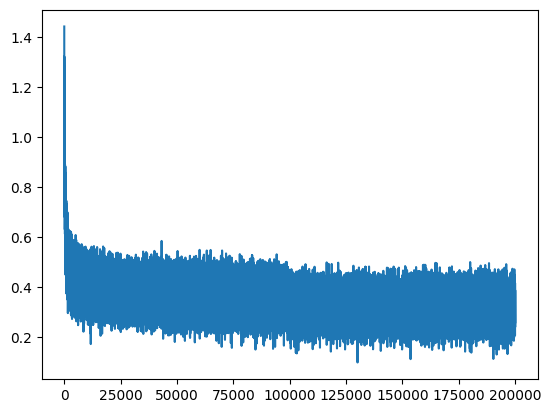

In [247]:
plt.plot(stepi, lossi) # Noise due to mini batches

In [248]:
# loss in training set batch

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1435, grad_fn=<NllLossBackward0>)

In [249]:
# loss in validation set batch

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1795, grad_fn=<NllLossBackward0>)

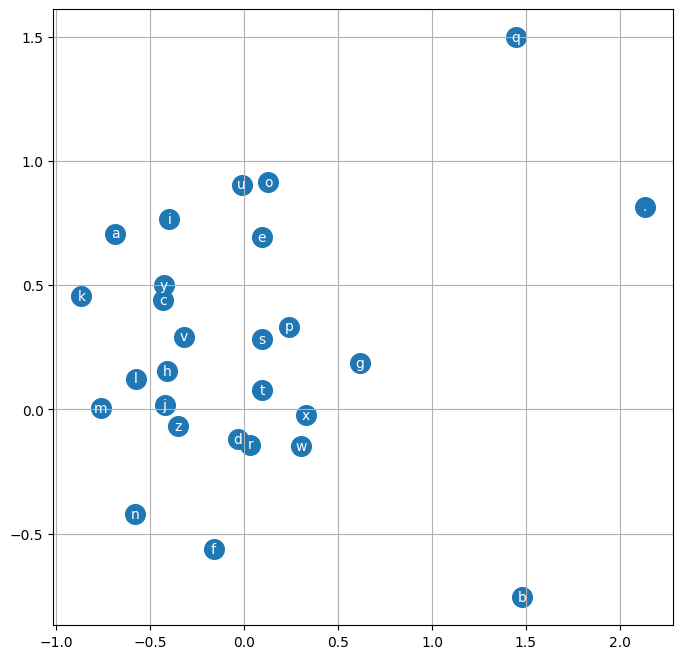

In [250]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [251]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mish.
tatyah.
cassie.
rahnee.
den.
rha.
kaeli.
nellara.
chaiiyan.
leigh.
ham.
jore.
quinn.
shon.
raiviani.
wazelo.
dearynix.
